In [29]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
from scipy.stats import spearmanr
import seaborn as sns

In [2]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures'):
    os.makedirs('figures')

In [3]:
download = False

## Load Data

In [4]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')


In [8]:
n_lead = 6

In [9]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}


## Precip Hindcast

In [10]:

for (nmme_name, nmme) in nmme_dict.items():
    print(f"######################")
    print(f"Processing NMME: {nmme_name.upper()}")
    print(f"######################")
    P_bar_all = nmme.mean(dim='M')['prec']
    P_bar = P_bar_all.sel(S=slice('1991-01-01','2020-12-31'))
    fcast_starts = P_bar['S'].values
    # Initialize storage
    x_range = P_bar['X'].values
    y_range = P_bar['Y'].values

    P_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)

    # Process each forecast start
    for s in range(len(fcast_starts)):
        print(f"Computing Precip forecast starting {fcast_starts[s]}")
        fcast_start = fcast_starts[s].astype('datetime64[s]').item()
        month = fcast_start.month

        # Compute climatology and anomalies
        P_bar_month = P_bar.sel(S=P_bar['S.month'] == month)
        P_c = P_bar_month.where(P_bar_month['S'] != fcast_starts[s]).mean(dim='S')
        P_a = P_bar - P_c

        ty_1 = fcast_start - relativedelta(years=1)
        ty_30 = fcast_start - relativedelta(years=30)

        obs_month = obs.sel(T=obs['T.month'] == month)
        obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
        P_fcst = P_a + obs_climo
        P_fcst_s = P_fcst.sel(S=fcast_start)
        # Create a new xarray with T as a dimension
        L_values = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5,6.5,7.5])[0:n_lead]
        T_values = [fcast_start + pd.DateOffset(months=int(L - 0.5)) for L in L_values]
        P_fcst = xr.concat(
            [P_fcst_s.sel(L=L).expand_dims(T=[T]) for L, T in zip(L_values, T_values)],
            dim="T"
        ).drop_vars('L')

        P_obs = obs.sel(T=slice(ty_30, fcast_start - relativedelta(months=1)))
        blend_series = xr.concat([P_obs, P_fcst], dim='T').sortby('T')
        blend_series_season = blend_series + blend_series.shift(T=1) + blend_series.shift(T=2)
        blend_series_season = blend_series_season.dropna('T').sortby('T')
        for l in range(n_lead):
            P_storage[s, l, :, :] = blend_series_season.isel(T=-n_lead+l).values


    P_s = xr.DataArray(
        P_storage,
        dims=['S', 'L', 'Y', 'X'],
        coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='precip')
    

    # Concatenate all forecasts
    P_fcst = xr.concat(P_s, dim='S')

    # Store the results
    precip_fcast_dict[nmme_name] = P_fcst
    # Save the results
    P_fcst.to_netcdf(f'data/precip_fcast_{nmme_name}.nc')



######################
Processing NMME: CFSV2
######################
Computing Precip forecast starting 1991-01-01T00:00:00.000000000
Computing Precip forecast starting 1991-02-01T00:00:00.000000000
Computing Precip forecast starting 1991-03-01T00:00:00.000000000
Computing Precip forecast starting 1991-04-01T00:00:00.000000000
Computing Precip forecast starting 1991-05-01T00:00:00.000000000
Computing Precip forecast starting 1991-06-01T00:00:00.000000000
Computing Precip forecast starting 1991-07-01T00:00:00.000000000
Computing Precip forecast starting 1991-08-01T00:00:00.000000000
Computing Precip forecast starting 1991-09-01T00:00:00.000000000
Computing Precip forecast starting 1991-10-01T00:00:00.000000000
Computing Precip forecast starting 1991-11-01T00:00:00.000000000
Computing Precip forecast starting 1991-12-01T00:00:00.000000000
Computing Precip forecast starting 1992-01-01T00:00:00.000000000
Computing Precip forecast starting 1992-02-01T00:00:00.000000000
Computing Precip fore

In [11]:
precip_fcast_multimodel = xr.concat([precip_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
precip_fcast_multimodel.to_netcdf(f'data/precip_fcast_multimodel.nc')

# Spi Hindcast

In [12]:
def compute_spi_single_grid(yy, xx, precip):
    precip_grid = precip.sel(X=x_range[xx], Y=y_range[yy])
    precip_grid = precip_grid.values
    #t = s + pd.DateOffset(months=int(l))
    #t_month = t.month

    if np.all(np.isnan(precip_grid)):  # Skip if all values are NaN
        return np.nan

    # Fit Pearson Type III distribution
    try:
        a, loc, scale = sp.stats.pearson3.fit(precip_grid)
        cdf_values = sp.stats.pearson3.cdf(precip_grid, skew=a, loc=loc, scale=scale)

        # Handle zero-inflated data
        q = np.sum(precip_grid == 0) / len(precip_grid)
        cdf_values = (cdf_values * (1 - q)) + q

        # Ensure CDF is within valid bounds
        cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

        # Convert CDF to SPI
        spi_time_series = sp.stats.norm.ppf(cdf_values)
        return spi_time_series
    except Exception as e:
        print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
        return np.nan

def compute_spi(precip):
    return Parallel(n_jobs=-1)(
        delayed(compute_spi_single_grid)(yy, xx, precip)
        for yy in range(len(y_range))
        for xx in range(len(x_range))
    )



In [13]:
for (nmme_name, p_fcast) in precip_fcast_dict.items():
    print(f"######################")
    print(f"Processing NMME: {nmme_name.upper()}")
    print(f"######################")
    # Initialize storage
    x_range = P_bar['X'].values
    y_range = P_bar['Y'].values
    fcast_starts = p_fcast['S'].values

    spi_storage_list = []

    for lead in range(n_lead):
        print(f"Computing SPI for lead time {lead + 1}")
        precip_L = p_fcast.isel(L=lead)
        spi_month_list =[]
        for month in range(1, 13):
            print(f"---- Computing SPI for month {month}")

            precip_L_month = precip_L.sel(S=precip_L['S.month'] == month)
            months = precip_L_month['S'].values

            spi = np.array(compute_spi(precip_L_month)).reshape(len(y_range), len(x_range), len(months))
            # transpose to match the xarray dimensions
            spi = np.transpose(spi, (2, 0, 1))
            spi_xr = xr.DataArray(
                spi,
                dims=['S','Y', 'X'],
                coords={'S': months, 'Y': y_range, 'X': x_range},
                name='spi'
            )
            spi_month_list.append(spi_xr)
        spi_month = xr.concat(spi_month_list, dim='S')
        spi_storage_list.append(spi_month)
    spi_storage = xr.concat(spi_storage_list, dim='L')
    #use the same L grid as precip forecast
    spi_storage['L'] = p_fcast['L']
    
    spi_fcast_dict[nmme_name] = spi_storage
    spi_storage.to_netcdf(f'data/spi_hindcast_{nmme_name}.nc')


######################
Processing NMME: CFSV2
######################
Computing SPI for lead time 1
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 3
---- Computing SPI for month 4
---- Computing SPI for month 5
---- Computing SPI for month 6
---- Computing SPI for month 7
---- Computing SPI for month 8
---- Computing SPI for month 9
---- Computing SPI for month 10
---- Computing SPI for month 11
---- Computing SPI for month 12
Computing SPI for lead time 2
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 3
---- Computing SPI for month 4
---- Computing SPI for month 5
---- Computing SPI for month 6
---- Computing SPI for month 7
---- Computing SPI for month 8
---- Computing SPI for month 9
---- Computing SPI for month 10
---- Computing SPI for month 11
---- Computing SPI for month 12
Computing SPI for lead time 3
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 

In [14]:
spi_hindcast_multimodel = xr.concat([spi_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
spi_hindcast_multimodel.to_netcdf(f'data/spi_hindcast_multimodel.nc')

# Skill

In [10]:
spi_cfsv2 = xr.open_dataset('data/spi_hindcast_cfsv2.nc').spi
spi_gfdlspear = xr.open_dataset('data/spi_hindcast_gfdlspear.nc').spi
spi_cesm1 = xr.open_dataset('data/spi_hindcast_cesm1.nc').spi
spi_colaccsm4 = xr.open_dataset('data/spi_hindcast_colaccsm4.nc').spi
spi_nasageos = xr.open_dataset('data/spi_hindcast_nasageos.nc').spi
spi_multimodel = xr.open_dataset('data/spi_hindcast_multimodel.nc').spi

precip_cfsv2 = xr.open_dataset('data/precip_fcast_cfsv2.nc').precip
precip_gfdlspear = xr.open_dataset('data/precip_fcast_gfdlspear.nc').precip
precip_cesm1 = xr.open_dataset('data/precip_fcast_cesm1.nc').precip
precip_colaccsm4 = xr.open_dataset('data/precip_fcast_colaccsm4.nc').precip
precip_nasageos = xr.open_dataset('data/precip_fcast_nasageos.nc').precip
precip_multimodel = xr.open_dataset('data/precip_fcast_multimodel.nc').precip

spi_hindcast_dict = {'cfsv2': spi_cfsv2, 'gfdlspear': spi_gfdlspear, 'cesm1': spi_cesm1, 'colaccsm4': spi_colaccsm4, 'nasageos': spi_nasageos,
                    'MME': spi_multimodel}

precip_fcast_dict = {'cfsv2': precip_cfsv2, 'gfdlspear': precip_gfdlspear, 'cesm1': precip_cesm1, 'colaccsm4': precip_colaccsm4, 'nasageos': precip_nasageos,
                    'MME': precip_multimodel}

for model in spi_fcast_dict.keys():
    if not os.path.exists(f'figures/hindcast/{model}'):
        os.makedirs(f'figures/hindcast/{model}')

In [11]:
n_lead=6

### Correlation

In [20]:
#kepp only forecat with Lead time 0.5 Target date in mon
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

threshold = 0.37

for nmme in spi_hindcast_dict.keys():
    spi_hindcast = spi_hindcast_dict[nmme]
    precip_fcast = precip_fcast_dict[nmme]
    for s_month in range(1, 13):
        for lead_time in range(n_lead):
            print(f"{nmme.upper()} - Processing month {s_month} with lead time {lead_time+1}")
            t_month = s_month + lead_time
            #have y_month computed as the modulo of 12 but 0 is 12
            t_month = t_month % 12
            if t_month == 0:
                t_month = 12
            season_str = 'Start: ' + months[s_month-1] + ' - ' 'Target: ' + seasons[t_month-1]
            save_str = 'start_' + months[s_month-1] + '_target_' + seasons[t_month-1]


            P_fcst_mon = precip_fcast.sel(S=precip_fcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            spi_fcst_mon = spi_hindcast.sel(S=spi_hindcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            
            #replace S by T and remove S
            S_values = spi_fcst_mon['S'].values
            T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
            #remove the S dimension
            P_fcst_mon['S'] = T_values
            spi_fcst_mon['S'] = T_values
            #rename S to T
            P_fcst_mon = P_fcst_mon.rename({'S':'T'})
            spi_fcst_mon = spi_fcst_mon.rename({'S':'T'})

            # Select the correct month for the observations
            P_obs_mon = obs_3m.sel(T=obs_3m['T.month'] == t_month)
            spi_obs_mon = spi_obs.sel(T=spi_obs['T.month'] == t_month)

            #keep same years for obs and forecast
            P_obs_mon = P_obs_mon.sel(T=P_fcst_mon['T'])
            spi_obs_mon = spi_obs_mon.sel(T=spi_fcst_mon['T'])

            ## plot the correlation map

            corr_map_p = xr.corr(P_fcst_mon, P_obs_mon, dim='T')
            corr_map_spi = xr.corr(spi_fcst_mon, spi_obs_mon, dim='T')

            levels = np.arange(-1, 1.1, 0.1)
            fig, axes = plt.subplots(
                nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
            )

            # Plot corr_obs_month
            corr_map_p.plot(
                vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[0],
                levels=levels
            )
            axes[0].coastlines()
            avg_corr = corr_map_p.mean().values
            axes[0].set_title(f'Precip Correlation', fontweight='bold')

            # Add dots for values > threshold
            mask_obs = corr_map_p > threshold
            x_obs = corr_map_p.coords['X'].values  # Replace 'lon' with your longitude coord name
            y_obs = corr_map_p.coords['Y'].values  # Replace 'lat' with your latitude coord name
            lon, lat = np.meshgrid(x_obs, y_obs)
            axes[0].scatter(
                lon[mask_obs], lat[mask_obs], color='black', s=10, transform=ccrs.PlateCarree(), label=f'Corr > {threshold}'
            )
            axes[0].legend(loc='lower right')

            # Plot corr_spi_month
            corr_map_spi.plot(
                vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[1],
                levels=levels
            )
            axes[1].coastlines()
            avg_corr = corr_map_spi.mean().values
            axes[1].set_title(f'SPI Correlation ', fontweight='bold')

            # Add dots for values > threshold
            mask_spi = corr_map_spi > threshold
            x_spi = corr_map_spi.coords['X'].values
            y_spi = corr_map_spi.coords['Y'].values
            lon, lat = np.meshgrid(x_spi, y_spi)
            axes[1].scatter(
                lon[mask_spi], lat[mask_spi], color='black', s=10, transform=ccrs.PlateCarree(), label=f'Corr > {threshold}'
            )
            axes[1].legend(loc='lower right')

            lead_string = str(lead_time + 0.5)

            plt.suptitle(f'{nmme.upper()} - {season_str}  (Lead {lead_string})', fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'figures/hindcast/{nmme}/corr_{save_str}.png')
            plt.close()



CFSV2 - Processing month 1 with lead time 1
CFSV2 - Processing month 1 with lead time 2
CFSV2 - Processing month 1 with lead time 3
CFSV2 - Processing month 1 with lead time 4
CFSV2 - Processing month 1 with lead time 5
CFSV2 - Processing month 1 with lead time 6
CFSV2 - Processing month 2 with lead time 1
CFSV2 - Processing month 2 with lead time 2
CFSV2 - Processing month 2 with lead time 3
CFSV2 - Processing month 2 with lead time 4
CFSV2 - Processing month 2 with lead time 5
CFSV2 - Processing month 2 with lead time 6
CFSV2 - Processing month 3 with lead time 1
CFSV2 - Processing month 3 with lead time 2
CFSV2 - Processing month 3 with lead time 3
CFSV2 - Processing month 3 with lead time 4
CFSV2 - Processing month 3 with lead time 5
CFSV2 - Processing month 3 with lead time 6
CFSV2 - Processing month 4 with lead time 1
CFSV2 - Processing month 4 with lead time 2
CFSV2 - Processing month 4 with lead time 3
CFSV2 - Processing month 4 with lead time 4
CFSV2 - Processing month 4 with 

In [15]:
def xr_spearman(a, b, dim='T'):
    """Compute Spearman correlation along a dimension of two xarray DataArrays."""
    def _spearman(x, y):
        # Remove NaNs pairwise
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 2:
            return np.nan
        return spearmanr(x[mask], y[mask])[0]

    return xr.apply_ufunc(
        _spearman,
        a,
        b,
        input_core_dims=[[dim], [dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

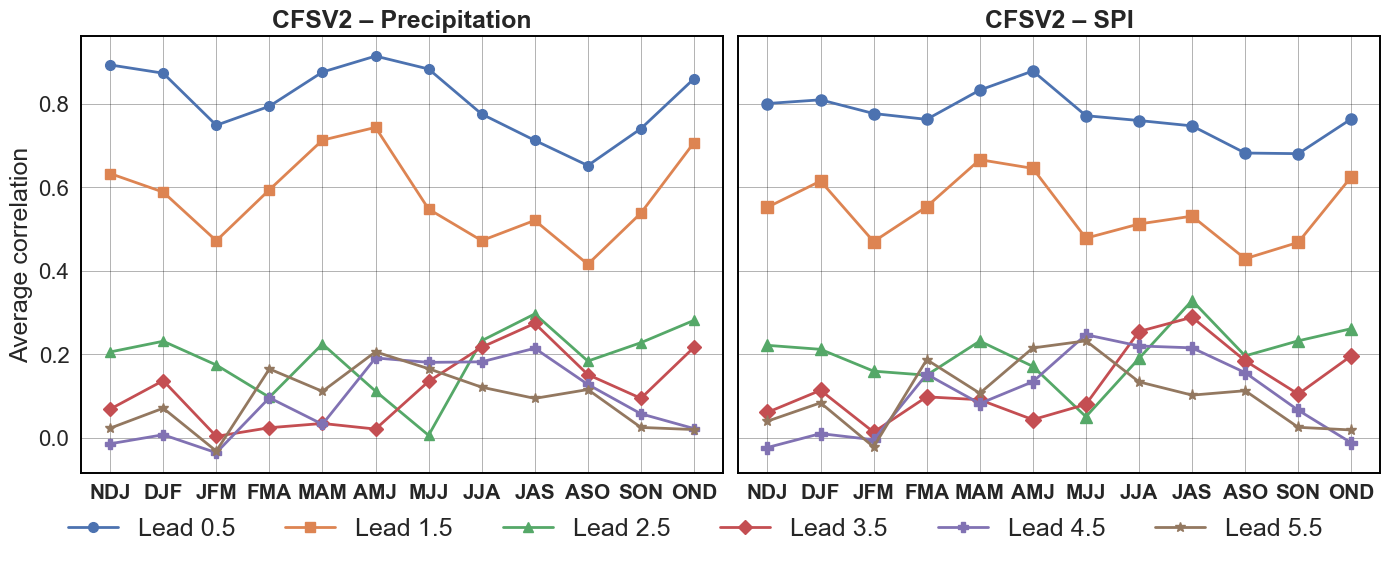

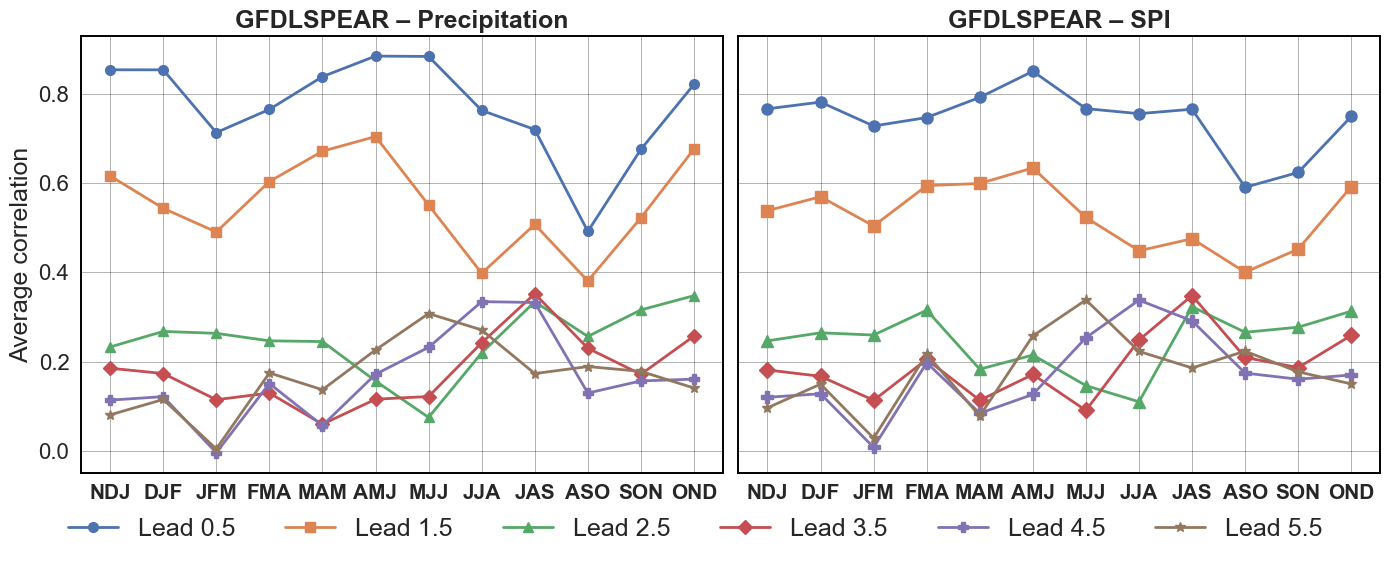

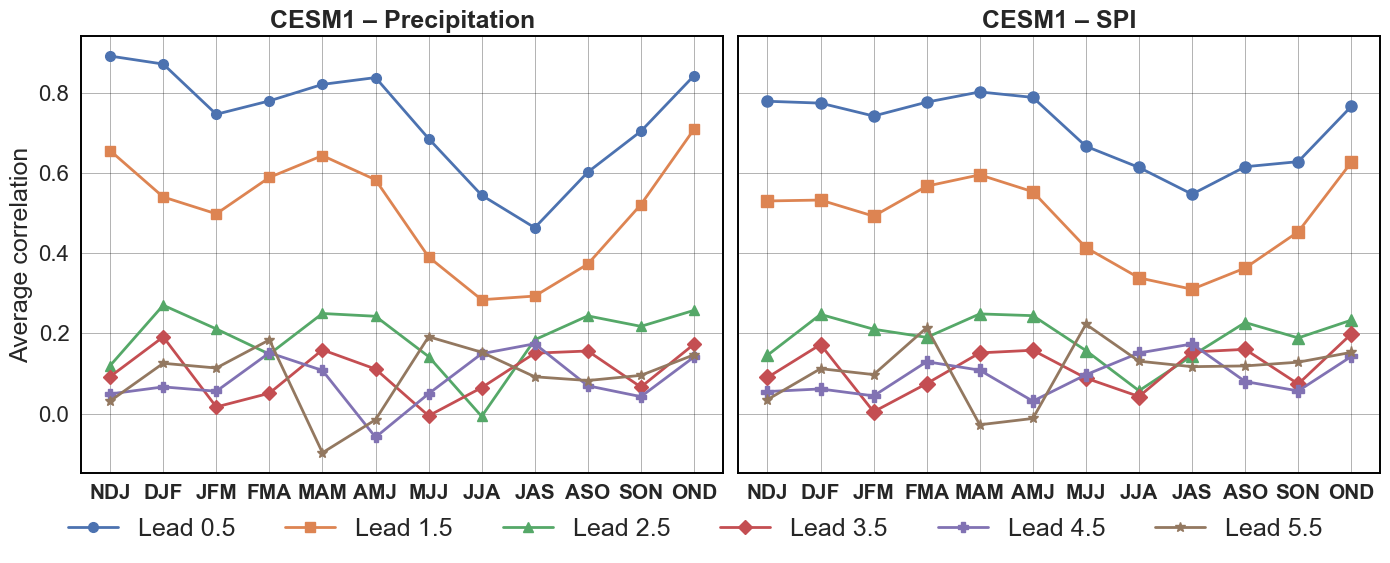

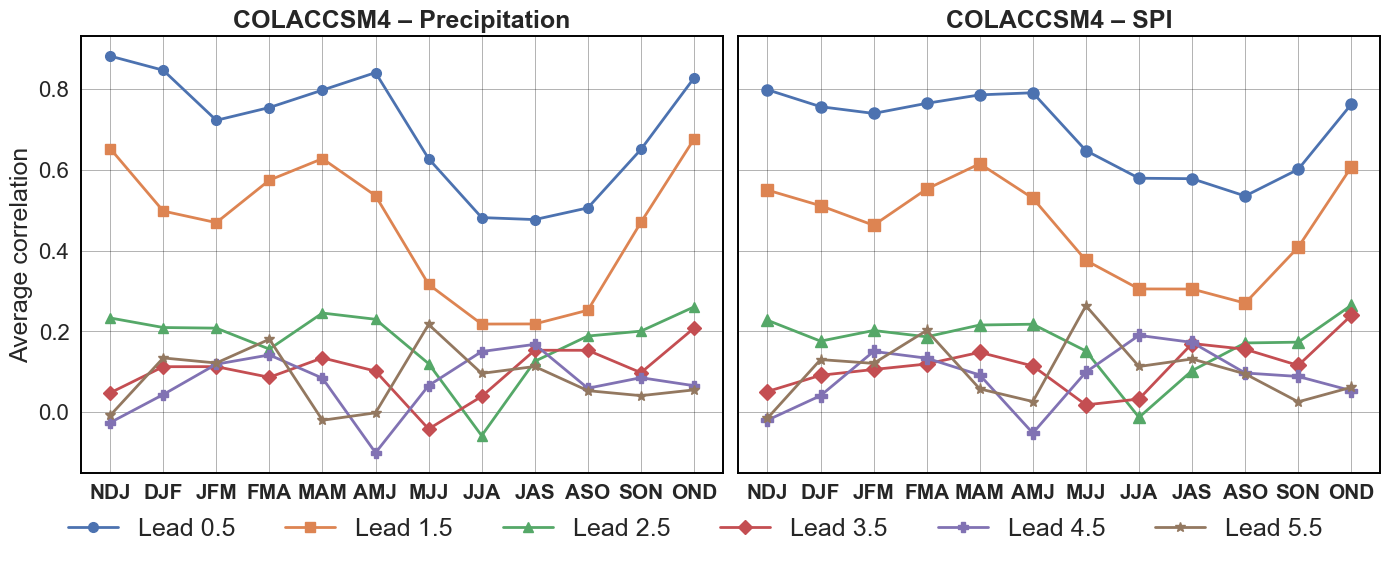

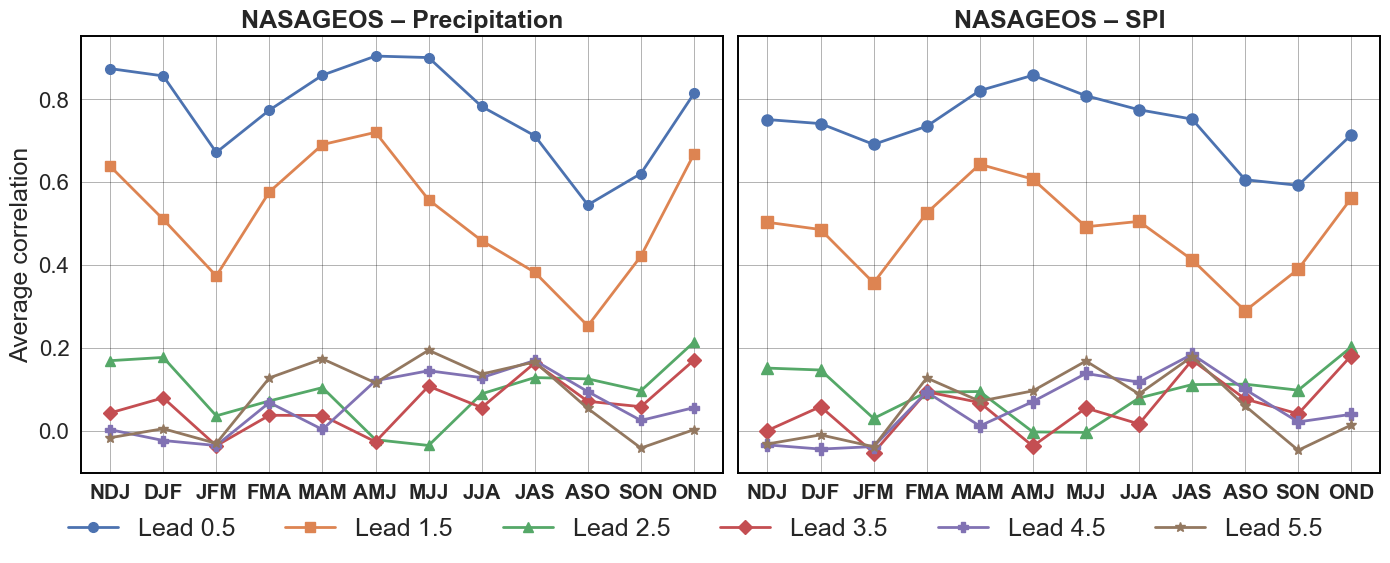

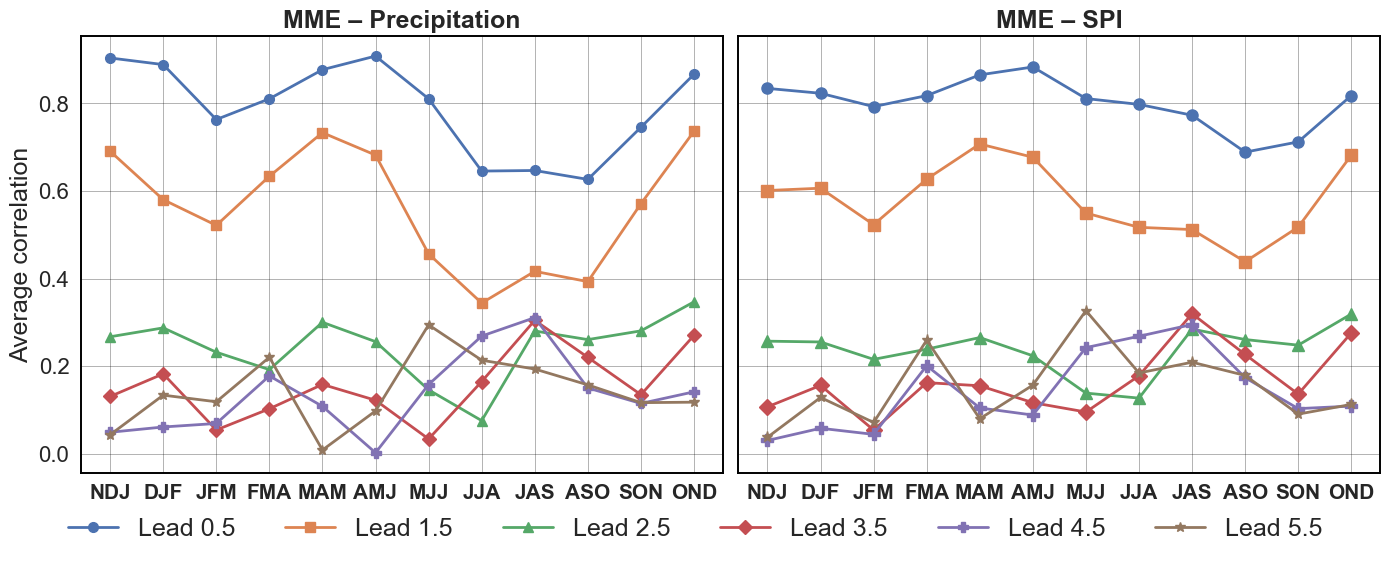

In [46]:
# --- settings for publication-ready plots ---
sns.set_style("whitegrid")
sns.set_context("paper")

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

threshold = 0.37

for nmme in spi_hindcast_dict.keys():
    spi_hindcast = spi_hindcast_dict[nmme]
    precip_fcast = precip_fcast_dict[nmme]

    # Store results for each lead time
    avg_corr_precip = {lt: [] for lt in range(n_lead)}
    avg_corr_spi = {lt: [] for lt in range(n_lead)}
    target_labels = []

    for s_month in range(1, 13):
        for lead_time in range(n_lead):
            t_month = (s_month + lead_time) % 12
            if t_month == 0:
                t_month = 12

            # Append target season label once per target month
            if lead_time == 0:
                target_labels.append(seasons[t_month-1])

            # Filter forecast for start month
            P_fcst_mon = precip_fcast.sel(S=precip_fcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            spi_fcst_mon = spi_hindcast.sel(S=spi_hindcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')

            # Shift S to T
            S_values = spi_fcst_mon['S'].values
            T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
            P_fcst_mon['S'] = T_values
            spi_fcst_mon['S'] = T_values
            P_fcst_mon = P_fcst_mon.rename({'S': 'T'})
            spi_fcst_mon = spi_fcst_mon.rename({'S': 'T'})

            # Observations for target month
            P_obs_mon = obs_3m.sel(T=obs_3m['T.month'] == t_month)
            spi_obs_mon = spi_obs.sel(T=spi_obs['T.month'] == t_month)

            # Align years
            P_obs_mon = P_obs_mon.sel(T=P_fcst_mon['T'])
            spi_obs_mon = spi_obs_mon.sel(T=spi_fcst_mon['T'])

            # Average Pearson correlation over domain
            avg_corr_precip[lead_time].append(xr.corr(P_fcst_mon, P_obs_mon, dim='T').mean().values)
            avg_corr_spi[lead_time].append(xr.corr(spi_fcst_mon, spi_obs_mon, dim='T').mean().values)

    # --- PLOTTING: publication quality ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    colors = sns.color_palette("deep", n_lead)
    markers = ['o', 's', '^', 'D', 'P', '*']

    # Precipitation correlations
    for i, (lt, corrs) in enumerate(avg_corr_precip.items()):
        axes[0].plot(
            target_labels, corrs,
            marker=markers[i % len(markers)], markersize=7,
            linewidth=2, color=colors[i],
            label=f'Lead {lt+0.5}'
        )

    axes[0].set_title(f'{nmme.upper()} – Precipitation', fontsize=18, fontweight='bold')
    axes[0].set_ylabel('Average correlation', fontsize=18)
    axes[0].set_xticks(range(len(target_labels)))
    axes[0].set_xticklabels(target_labels, rotation=0, ha='center', fontsize=15, fontweight='bold')
    axes[0].tick_params(axis='y', labelsize=16)

    # SPI correlations
    for i, (lt, corrs) in enumerate(avg_corr_spi.items()):
        axes[1].plot(
            target_labels, corrs,
            marker=markers[i % len(markers)], markersize=8,
            linewidth=2, color=colors[i],
            label=f'Lead {lt+0.5}'
        )

    axes[1].set_title(f'{nmme.upper()} – SPI', fontsize=18, fontweight='bold')
    axes[1].set_xticks(range(len(target_labels)))
    axes[1].set_xticklabels(target_labels, rotation=0, ha='center', fontsize=15,  fontweight='bold')
    axes[1].tick_params(axis='y', labelsize=16)

    # Make all spines and grid black
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.4)

        # Add grid with black lines
        ax.grid(True, color='black', linestyle='-', linewidth=0.7, alpha=0.3)

    # Common legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='lower center', ncol=n_lead,
        fontsize=18, frameon=False
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # reserve space for legend
    plt.show()
    # Save publication-quality version
    plt.savefig(f'figures/hindcast/{nmme}/avg_corr_summary.png', dpi=300)
    plt.close()

### RMSE

In [27]:
def rmspe(fcst, obs):
    ''' Compute the Root Mean Square Percentage Error (RMSPE) between two xarray DataArrays. '''
    return np.sqrt((((fcst - obs)) ** 2).mean(dim='T')) 

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

for nmme in spi_hindcast_dict.keys():
    spi_hindcast = spi_hindcast_dict[nmme]
    precip_fcast = precip_fcast_dict[nmme]
    for s_month in range(1, 13):
        for lead_time in range(n_lead):
            print(f"{nmme.upper()} - Processing month {s_month} with lead time {lead_time+1}")
            t_month = s_month + lead_time
            #have y_month computed as the modulo of 12 but 0 is 12
            t_month = t_month % 12
            if t_month == 0:
                t_month = 12
            season_str = 'Start: ' + months[s_month-1] + ' - ' 'Target: ' + seasons[t_month-1]
            save_str = 'start_' + months[s_month-1] + '_target_' + seasons[t_month-1]


            P_fcst_mon = precip_fcast.sel(S=precip_fcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            spi_fcst_mon = spi_hindcast.sel(S=spi_hindcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            
            #replace S by T and remove S
            S_values = spi_fcst_mon['S'].values
            T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
            #remove the S dimension
            P_fcst_mon['S'] = T_values
            spi_fcst_mon['S'] = T_values
            #rename S to T
            P_fcst_mon = P_fcst_mon.rename({'S':'T'})
            spi_fcst_mon = spi_fcst_mon.rename({'S':'T'})

            # Select the correct month for the observations
            P_obs_mon = obs_3m.sel(T=obs_3m['T.month'] == t_month)
            spi_obs_mon = spi_obs.sel(T=spi_obs['T.month'] == t_month)

            #keep same years for obs and forecast
            P_obs_mon = P_obs_mon.sel(T=P_fcst_mon['T'])
            spi_obs_mon = spi_obs_mon.sel(T=spi_fcst_mon['T'])

            ## plot the RMSE map

            rmse_map_p = rmspe(P_fcst_mon, P_obs_mon)
            rmse_map_spi = rmspe(spi_fcst_mon, spi_obs_mon)

            levels = 21
            fig, axes = plt.subplots(
                nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
            )

            # Plot corr_obs_month
            rmse_map_p.plot(
                vmin=0, vmax=10, cmap='OrRd', cbar_kwargs={'label': 'RMSE'}, ax=axes[0],
                levels=levels
            )
            axes[0].coastlines()
            axes[0].set_title(f'Precip RMSE', fontweight='bold')

            # Plot corr_spi_month
            rmse_map_spi.plot(
                vmin=0, vmax=3, cmap='OrRd', cbar_kwargs={'label': 'RMSE'}, ax=axes[1],
                levels=levels
            )
            axes[1].coastlines()
            axes[1].set_title(f'SPI RMSE ', fontweight='bold')


            lead_string = str(lead_time + 0.5)

            plt.suptitle(f'{nmme.upper()} - {season_str}  (Lead {lead_string})', fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'figures/hindcast/{nmme}/RMSE_{save_str}.png')
            plt.close()


CFSV2 - Processing month 1 with lead time 1
CFSV2 - Processing month 1 with lead time 2
CFSV2 - Processing month 1 with lead time 3
CFSV2 - Processing month 1 with lead time 4
CFSV2 - Processing month 1 with lead time 5
CFSV2 - Processing month 1 with lead time 6
CFSV2 - Processing month 2 with lead time 1
CFSV2 - Processing month 2 with lead time 2
CFSV2 - Processing month 2 with lead time 3
CFSV2 - Processing month 2 with lead time 4
CFSV2 - Processing month 2 with lead time 5
CFSV2 - Processing month 2 with lead time 6
CFSV2 - Processing month 3 with lead time 1
CFSV2 - Processing month 3 with lead time 2
CFSV2 - Processing month 3 with lead time 3
CFSV2 - Processing month 3 with lead time 4
CFSV2 - Processing month 3 with lead time 5
CFSV2 - Processing month 3 with lead time 6
CFSV2 - Processing month 4 with lead time 1
CFSV2 - Processing month 4 with lead time 2
CFSV2 - Processing month 4 with lead time 3
CFSV2 - Processing month 4 with lead time 4
CFSV2 - Processing month 4 with 

### Bias

In [45]:
def bias(fcst, obs):
    return (fcst - obs).mean(dim='T')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

for nmme in spi_hindcast_dict.keys():
    spi_hindcast = spi_hindcast_dict[nmme]
    precip_fcast = precip_fcast_dict[nmme]
    for s_month in range(1, 13):
        for lead_time in range(n_lead):
            print(f"{nmme.upper()} - Processing month {s_month} with lead time {lead_time+1}")
            t_month = s_month + lead_time
            #have y_month computed as the modulo of 12 but 0 is 12
            t_month = t_month % 12
            if t_month == 0:
                t_month = 12
            season_str = 'Start: ' + months[s_month-1] + ' - ' 'Target: ' + seasons[t_month-1]
            save_str = 'start_' + months[s_month-1] + '_target_' + seasons[t_month-1]


            P_fcst_mon = precip_fcast.sel(S=precip_fcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            spi_fcst_mon = spi_hindcast.sel(S=spi_hindcast['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
            
            #replace S by T and remove S
            S_values = spi_fcst_mon['S'].values
            T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
            #remove the S dimension
            P_fcst_mon['S'] = T_values
            spi_fcst_mon['S'] = T_values
            #rename S to T
            P_fcst_mon = P_fcst_mon.rename({'S':'T'})
            spi_fcst_mon = spi_fcst_mon.rename({'S':'T'})

            # Select the correct month for the observations
            P_obs_mon = obs_3m.sel(T=obs_3m['T.month'] == t_month)
            spi_obs_mon = spi_obs.sel(T=spi_obs['T.month'] == t_month)

            #keep same years for obs and forecast
            P_obs_mon = P_obs_mon.sel(T=P_fcst_mon['T'])
            spi_obs_mon = spi_obs_mon.sel(T=spi_fcst_mon['T'])

            ## plot the bias map

            bias_map_p = bias(P_fcst_mon, P_obs_mon)
            bias_map_spi = bias(spi_fcst_mon, spi_obs_mon)

            levels = 21
            fig, axes = plt.subplots(
                nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
            )

            # Plot corr_obs_month
            bias_map_p.plot(
                vmin=-2, vmax=2, cmap='RdBu_r', cbar_kwargs={'label': 'Bias'}, ax=axes[0],
                levels=levels
            )
            axes[0].coastlines()
            axes[0].set_title(f'Precip Bias', fontweight='bold')

            # Plot corr_spi_month
            bias_map_spi.plot(
                vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'bias'}, ax=axes[1],
                levels=levels
            )
            axes[1].coastlines()
            axes[1].set_title(f'SPI Bias ', fontweight='bold')


            lead_string = str(lead_time + 0.5)

            plt.suptitle(f'{nmme.upper()} - {season_str}  (Lead {lead_string})', fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'figures/hindcast/{nmme}/bias_{save_str}.png')
            plt.close()


CFSV2 - Processing month 1 with lead time 1
CFSV2 - Processing month 1 with lead time 2
CFSV2 - Processing month 1 with lead time 3
CFSV2 - Processing month 1 with lead time 4
CFSV2 - Processing month 1 with lead time 5
CFSV2 - Processing month 1 with lead time 6
CFSV2 - Processing month 2 with lead time 1
CFSV2 - Processing month 2 with lead time 2
CFSV2 - Processing month 2 with lead time 3
CFSV2 - Processing month 2 with lead time 4
CFSV2 - Processing month 2 with lead time 5
CFSV2 - Processing month 2 with lead time 6
CFSV2 - Processing month 3 with lead time 1
CFSV2 - Processing month 3 with lead time 2
CFSV2 - Processing month 3 with lead time 3
CFSV2 - Processing month 3 with lead time 4
CFSV2 - Processing month 3 with lead time 5
CFSV2 - Processing month 3 with lead time 6
CFSV2 - Processing month 4 with lead time 1
CFSV2 - Processing month 4 with lead time 2
CFSV2 - Processing month 4 with lead time 3
CFSV2 - Processing month 4 with lead time 4
CFSV2 - Processing month 4 with 